# get some random samples of pmids from the pubmed database
#   write the pmids to json files

out of curiosity, how contiguous are the pmids?

In [1]:


import json
import mysql.connector as mysql

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import Row, StructType, StructField, IntegerType, StringType

import os
import time
import random
import numpy as np

import matplotlib.pyplot as plt
#import cairocffi as cairo


In [2]:
SUBMIT_ARGS = "--driver-class-path file:///home/brendanchambers/my_resources/mysql-connector-java-8.0.16/mysql-connector-java-8.0.16.jar --jars file:///home/brendanchambers/my_resources/mysql-connector-java-8.0.16/mysql-connector-java-8.0.16.jar pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS

db_name = 'test_pubmed'  # db name collisons? https://stackoverflow.com/questions/14011968/user-cant-access-a-database
url = "jdbc:mysql://localhost:3306/{}?useUnicode=true&useJDBCCompliantTimezoneShift=true&useLegacyDatetimeCode=false&serverTimezone=America/Chicago".format(db_name)  # mysql runs on port 3306
client_config = {'unix_socket':'/home/brendanchambers/.sql.sock',
                'database': db_name}  # for python connector

In [3]:
print('initializing spark')
# init spark
conf = SparkConf()
conf = (conf.setMaster('local[*]')
       .set('spark.driver.memory','60G')
       .set("spark.jars", "/home/brendanchambers/my_resources/mysql-connector-java-8.0.16/mysql-connector-java-8.0.16.jar"))        
'''
.set('spark.executor.memory','1G')  # 20
.set('spark.driver.memory','1G')   # 40
.set('spark.driver.maxResultSize','500M')  #.set('spark.storage.memoryFraction',0))  # this setting is now a legacy option
.set('spark.python.worker.reuse', 'false')
.set('spark.python.worker.memory','512m')
.set('spark.executor.cores','1'))
'''
sc = SparkContext(conf=conf)
#sc.addJar('home/brendanchambers/my_resources/mysql-connector-java-8.0.16/mysql-connector-java-8.0.16.jar')  # temp
spark = SparkSession(sc)  # don't need this for vanilla RDDs

print(sc._conf.getAll())

initializing spark
[('spark.driver.host', 'midway2-0157.rcc.local'), ('spark.repl.local.jars', 'file:///home/brendanchambers/my_resources/mysql-connector-java-8.0.16/mysql-connector-java-8.0.16.jar'), ('spark.jars', '/home/brendanchambers/my_resources/mysql-connector-java-8.0.16/mysql-connector-java-8.0.16.jar'), ('spark.driver.port', '39139'), ('spark.executor.id', 'driver'), ('spark.app.name', 'pyspark-shell'), ('spark.app.id', 'local-1568056696828'), ('spark.rdd.compress', 'True'), ('spark.driver.extraClassPath', 'file:///home/brendanchambers/my_resources/mysql-connector-java-8.0.16/mysql-connector-java-8.0.16.jar'), ('spark.serializer.objectStreamReset', '100'), ('spark.master', 'local[*]'), ('spark.driver.memory', '60G'), ('spark.submit.deployMode', 'client'), ('spark.ui.showConsoleProgress', 'true')]


## load in full list of pmids

In [5]:
tablename_ = 'metadata'

sql = "(SELECT pmid, year, journal FROM {}) AS t".format(tablename_)
print(sql)

start_time = time.time()
df_pmids = spark.read.format('jdbc').option("url", url)\
                              .option("dbtable", sql)\
                              .load().repartition(25).cache()
end_time = time.time()
print("dataframe loaded in {} s".format(end_time - start_time))

print(df_pmids.rdd.getNumPartitions())

(SELECT pmid, year, journal FROM metadata) AS t
dataframe loaded in 0.07427811622619629 s
25


## get samples of pmids

(target ~100,000 samples)

In [22]:
N_samples = 10
sample_bank = []

do_resample = False
sample_fraction = 0.0033333   # target sample size ~100k

for i_sam in range(N_samples):
    
    start_time = time.time()

    sample_rows = df_pmids.sample(do_resample, sample_fraction)\
                .rdd.map(lambda row: (row[0],row[1],row[2]) )
    
    new_sample = sample_rows.collect() # todo reformat for serialization?
    sample_bank.append(new_sample)
    
    print()
    print(new_sample[:10])
    print()

    end_time = time.time()
    print("elapsed: {}".format(end_time - start_time))




[(25970969, 2015, 'Rev Med Chir Soc Med Nat Iasi'), (18005910, 2007, 'Explore (NY)'), (944382, 1976, 'Nature'), (15443245, 1950, 'Veska'), (14172513, 1964, 'Percept Mot Skills'), (20581438, 2010, 'Cell Cycle'), (7265613, 1981, 'Kardiol Pol'), (11043898, 2000, 'J Sports Sci'), (1470424, 1992, 'Nucl Med Commun'), (19033446, 2009, 'J. Biol. Chem.')]

elapsed: 0.6016771793365479

[(16250618, 2005, 'Rozhl Chir'), (8639363, 1996, 'Br Dent J'), (19816302, 2009, 'J Craniofac Surg'), (11314480, 2000, 'J Dent Hyg'), (2015784, 1991, 'Dtsch. Med. Wochenschr.'), (5061526, 1972, 'Nouv Presse Med'), (10644766, 2000, 'J. Biol. Chem.'), (16119464, 2005, 'Bioorg. Khim.'), (1463049, 1992, 'Am. J. Ophthalmol.'), (8293755, 1993, 'Eur. Heart J.')]

elapsed: 0.6313433647155762

[(7087672, 1982, 'Life Sci.'), (944382, 1976, 'Nature'), (8653311, 1996, 'Br J Urol'), (6861627, 1983, 'Drug Intell Clin Pharm'), (8206086, 1994, 'Eur. J. Immunol.'), (1553711, 1992, 'Tidsskr. Nor. Laegeforen.'), (18414555, 2008, 'Op

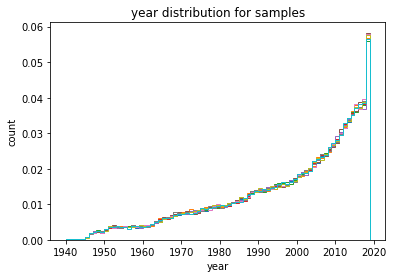

In [23]:
plt.figure()

for i_sam in range(N_samples):
    
    year_contents = [row[1] for row in sample_bank[i_sam]]
    
    plt.hist(year_contents, histtype='step',
            density=True, bins=np.arange(1940,2020))
    
    
plt.title('year distribution for samples')
plt.xlabel('year')
plt.ylabel('count')
plt.show()

In [24]:
for i_sam in range(N_samples):
    
    outpath = '/project2/jevans/brendan/pubmed_data_processing/sample_pmids/'
    filename = outpath + 'sample' + str(i_sam) + '.json'
    
    save_obj = {'sample_fraction': sample_fraction,
               'do_resample': do_resample,
               'sample_rows': sample_bank[i_sam]}
    
    with open(filename, 'w') as f:
        json.dump(save_obj, f)

In [ ]:

# look at distribution of years